# 文件导入

In [1]:
import pandas as pd
import numpy as np
import re
import argparse
pd.options.display.max_rows = 200
import amsterdamumcdb as adb

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(
        description='''Compare the number of cases of sepsis at admission for
            for the Sepsis-3 and the previous sepsis definition.''')
    parser.add_argument(
        '--data_file_path',
        default='../../AmsterdamUMCdb-v1/',
        help='''File path to the directory that contains the base
            AmsterdamUMCdb .csv files. These files are not directly available
            from the AmsterdamUMCdb GitHub page, and access must be
            specifically requested from Amsterdam UMC.
            (default: %(default)s)''',
        type=str)
    parser.add_argument(
        '--output_file_path',
        default='./out/',
        help='''File path to the directory that will contain the output of this
            script, which should be the same output file path as in the script
            sepsis3_amsterdamumcdb.py (default: %(default)s)''',
        type=str)
    parser.add_argument(
        '--print_reason_for_admission_table',
        default=False,
        help='''Print the reason admission table giving the number admissions
        in various surgical and medical categories (default: %(default)s)''',
        type=bool)
    args = parser.parse_args(args=[])
    return args

inputs = parse_args()

In [ ]:
dictionary = adb.get_dictionary()

list_columns = ['admissionid', 'itemid', 'valueid', 'value']
list_columns += ['measuredat', 'updatedat', 'registeredby']
listitems = pd.read_csv(
    inputs.data_file_path + 'listitems.csv', usecols=list_columns, encoding='latin-1')

drug_columns = ['admissionid', 'itemid', 'item', 'duration', 'rate']
drug_columns += ['rateunit', 'start', 'stop', 'dose', 'doserateperkg']
drug_columns += ['doseunitid', 'doserateunitid', 'ordercategoryid']
drugitems = pd.read_csv(
    inputs.data_file_path + 'drugitems.csv', usecols=drug_columns, encoding='latin-1')

procedureorder_columns = ['admissionid', 'itemid', 'item', 'registeredat']
procedureorderitems = pd.read_csv(
    inputs.data_file_path + 'procedureorderitems.csv',
    usecols=procedureorder_columns, encoding='latin-1')

freetextitems = pd.read_csv(inputs.data_file_path + 'freetextitems.csv', encoding='latin-1')



# 肌酐与尿量数据获取

In [3]:
numerics_cols = ['admissionid', 'itemid', 'item', 'value', 'unitid']
numerics_cols += ['measuredat', 'registeredby', 'islabresult', 'fluidout']
numerics_dtypes = ['int64', 'int64', 'str', 'float64', 'int64']
numerics_dtypes += ['int64', 'str', 'bool', 'float64']
numerics_dtypes = dict(zip(numerics_cols, numerics_dtypes))
numerics_csv = dict(
    encoding='latin-1', usecols=numerics_cols, dtype=numerics_dtypes,
    chunksize=10**6)

def numerics_read(itemid_list, start=None, end=None, admissions_df=None):
    numerics_list = []
    ii = 0
    if admissions_df is not None:
        admissions_df = admissions_df[['admissionid', 'admittedat']]
    file_name =  '../../AmsterdamUMCdb-v1/numericitems.csv'
    with pd.read_csv(file_name, **numerics_csv) as reader:
        for chunk in reader:
            if ((ii % 100) == 0):
                print(ii)
            chunk = chunk.loc[chunk['itemid'].isin(itemid_list)]
            if admissions_df is not None:
                chunk = pd.merge(
                    chunk, admissions_df,
                    on='admissionid', how='left')
                chunk['diff_measuredat'] = (
                    chunk['measuredat'] - chunk['admittedat'])
            else:
                chunk['diff_measuredat'] = chunk['measuredat']
            if start is not None:
                chunk = chunk.loc[chunk['diff_measuredat'] >= start]
            if end is not None:
                chunk = chunk.loc[chunk['diff_measuredat'] <= end]
            numerics_list.append(chunk)
            ii += 1
    numerics = pd.concat(numerics_list)
    numerics['time'] = numerics['diff_measuredat'] // (1000*60*60) #转换为小时
    numerics.drop(columns=['diff_measuredat'], inplace=True)
    numerics.reset_index(drop=True, inplace=True)
    return numerics

In [ ]:
# This list is taken from the AmsterdamUMCdb SOFA scores script.
numerics_uo_itemid = [8794]  # UrineCAD
numerics_uo_itemid += [8796]  # UrineSupraPubis
numerics_uo_itemid += [8798]  # UrineSpontaan
numerics_uo_itemid += [8800]  # UrineIncontinentie
numerics_uo_itemid += [8803]  # UrineUP
numerics_uo_itemid += [10743]  # Nefrodrain li Uit
numerics_uo_itemid += [10745]  # Nefrodrain re Uit
numerics_uo_itemid += [19921]  # UrineSplint Li
numerics_uo_itemid += [19922]  # UrineSplint Re]

numerics_creatinine_itemid = [6836]  # 6836: Kreatinine µmol/l ...
# (erroneously documented as µmol)
numerics_creatinine_itemid += [9941]  # Kreatinine (bloed) µmol/l
numerics_creatinine_itemid += [14216]  # KREAT enzym. (bloed) µmol/l

end_time = None # 1000*60*60*24*10 # 入ICU后14天的数据
start_time = 0
numerics_uo = numerics_read(
    numerics_uo_itemid, admissions_df=None,
    end=end_time, start=start_time)
# We need a baseline creatinine, so look back further.
numerics_creatinine = numerics_read(
    numerics_creatinine_itemid, admissions_df=None,
    end=end_time, start=-1000*60*60*24*365)

#numerics_creatinine.to_csv("AKI_for_creatinine.csv",index=False)
#numerics_uo.to_csv("AKI_for_uo.csv",index=False)

# 定义AKI
- 肌酐升高一定值是指48小时内升高
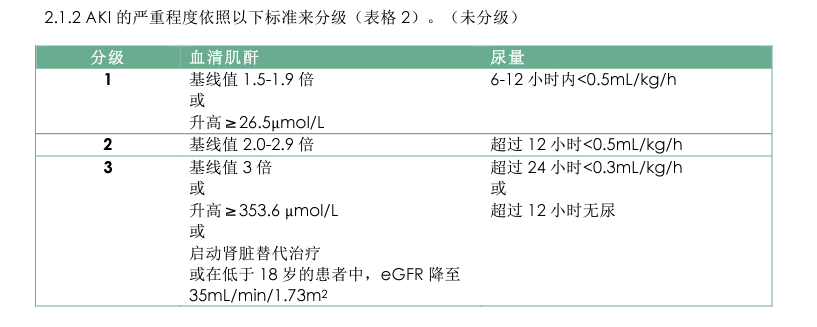

# 尿量定义AKI

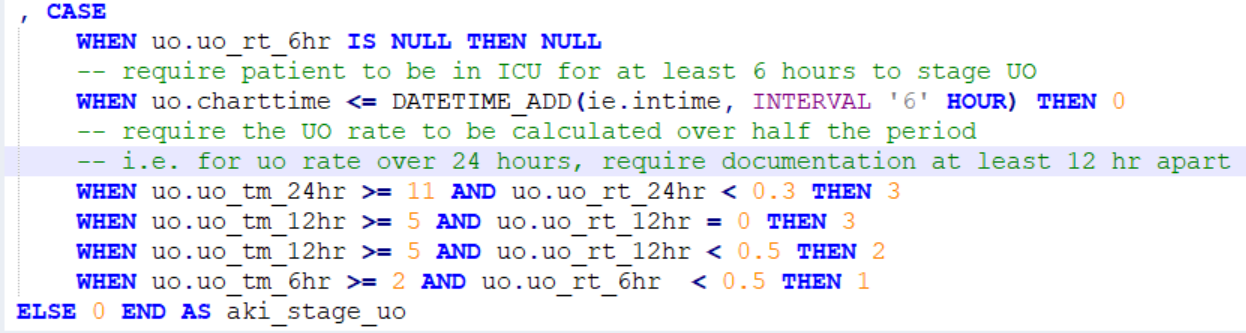

In [4]:
## -- Get urineoutput hourly -- ##
numerics_uo = pd.read_csv("AKI_for_uo.csv")
numerics_uo = numerics_uo.sort_values(["admissionid","measuredat"])

sofa_ruo_itemid = [8794]
sofa_ruo_itemid += [8796]
sofa_ruo_itemid += [8798]
sofa_ruo_itemid += [8800]
sofa_ruo_itemid += [8803]
sofa_ruo_itemid += [10743]
sofa_ruo_itemid += [10745]
sofa_ruo_itemid += [19921]
sofa_ruo_itemid += [19922]
# Dataframe is called sofa_renal_urine_output in amsterdamUMCdb sofa script
sofa_urine_output = numerics_uo.loc[
    numerics_uo['itemid'].isin(sofa_ruo_itemid)]
sofa_urine_output.drop(
    columns=['unitid', 'measuredat', 'fluidout'],
    inplace=True)
sofa_urine_output.head()

# Probably decimal error when entering volumes > 2500
sofa_urine_output.loc[(sofa_urine_output['value'] > 2500), 'value'] /= 10
# Remove extreme outliers, most likely data entry error)
sofa_urine_output.loc[(sofa_urine_output['value'] > 4500), 'value'] = np.nan
sofa_urine_output = sofa_urine_output.dropna(subset=['value'])

# Get urine output per hours
sofa_hourly_urine_output = \
    sofa_urine_output.groupby(['admissionid', 'time']).agg(
        hourly_urine_output=pd.NamedAgg(column='value', aggfunc='sum')
    ).reset_index()
sofa_hourly_urine_output = sofa_hourly_urine_output.sort_values(["admissionid","time"])

#添加入院时间
tmp_df = pd.read_csv(inputs.data_file_path + 'admissions.csv', encoding='latin-1')
tmp_df = tmp_df[["admissionid","admittedat"]]
tmp_df["admittedat"] = tmp_df["admittedat"]/(1000*60*60)
sofa_hourly_urine_output = pd.merge(sofa_hourly_urine_output,tmp_df,how="left",on="admissionid")

sofa_hourly_urine_output.head()


,admissionid,time,hourly_urine_output,admittedat
0,0,5,90.0,0.0
1,0,6,310.0,0.0
2,0,7,360.0,0.0
3,0,8,180.0,0.0
4,0,9,120.0,0.0


In [5]:
# ## -- 填补时间 -- ##
com_lst = []
for i in sofa_hourly_urine_output.admissionid.unique().tolist():
    start_t = int(max(sofa_hourly_urine_output[sofa_hourly_urine_output.admissionid==i].admittedat))
    max_t = max(sofa_hourly_urine_output[sofa_hourly_urine_output.admissionid==i].time)
    for j in range(start_t,max_t+1,1):
        com_lst.append([i,j])
df_complete = pd.DataFrame(com_lst,columns=["admissionid", "time"])            

sofa_hourly_urine_output_add = pd.merge(df_complete,sofa_hourly_urine_output, how="left", on=["admissionid","time"])
sofa_hourly_urine_output_add = sofa_hourly_urine_output_add.fillna(0)
sofa_hourly_urine_output_add = sofa_hourly_urine_output_add.loc[(sofa_hourly_urine_output_add["time"]-sofa_hourly_urine_output_add["admittedat"])<90,:]
sofa_hourly_urine_output_add.head(1)

,admissionid,time,hourly_urine_output,admittedat
0,0,0,0.0,0.0


In [6]:
## 获取过去6小时，12小时，24小时的尿量 ##
tmp_df = pd.DataFrame()
for i,j in sofa_hourly_urine_output_add.groupby("admissionid"):
    j["uo_b6hr"] = j["hourly_urine_output"].rolling(window=6,min_periods=1).sum()
    j["uo_b12hr"] = j["hourly_urine_output"].rolling(window=12,min_periods=1).sum()
    j["uo_b24hr"] = j["hourly_urine_output"].rolling(window=24,min_periods=1).sum()
    tmp_df = pd.concat([tmp_df,j],axis=0)
sofa_hourly_urine_output_add = tmp_df
# sofa_hourly_urine_output_add["uo_b6hr"] = sofa_hourly_urine_output_add["hourly_urine_output"].rolling(window=6,min_periods=1).sum()
# sofa_hourly_urine_output_add["uo_b12hr"] = sofa_hourly_urine_output_add["hourly_urine_output"].rolling(window=12,min_periods=1).sum()
# sofa_hourly_urine_output_add["uo_b24hr"] = sofa_hourly_urine_output_add["hourly_urine_output"].rolling(window=24,min_periods=1).sum()


In [7]:
## 获取体重 ##
admissions_df = pd.read_csv(inputs.data_file_path + 'admissions.csv', encoding='latin-1')
weightgroup_dict = {'60-69':65, '70-79':75, '90-99':95, '100-109':105, '80-89':85, '59-':59, "nan":np.nan, '110+':110}
admissions_df["weight"] = admissions_df["weightgroup"].map(weightgroup_dict)
admissions_df = admissions_df[["admissionid","weight"]]

## 获取尿量速率 ##
sofa_hourly_urine_output_add = pd.merge(sofa_hourly_urine_output_add,admissions_df,how="left",on="admissionid")
sofa_hourly_urine_output_add["uo_b6hr_r"] =  round(sofa_hourly_urine_output_add["uo_b6hr"] / 6/sofa_hourly_urine_output_add["weight"],1)
sofa_hourly_urine_output_add["uo_b12hr_r"] =  round(sofa_hourly_urine_output_add["uo_b12hr"] / 12/sofa_hourly_urine_output_add["weight"],1)
sofa_hourly_urine_output_add["uo_b24hr_r"] =  round(sofa_hourly_urine_output_add["uo_b24hr"] / 24/sofa_hourly_urine_output_add["weight"],1)


In [8]:
## 通过尿量定义AKI ##
uo = sofa_hourly_urine_output_add
uo.loc[(uo["hourly_urine_output"]!=0),"aki_stage_uo"] = 0
uo.loc[((uo['time'] > 2) & (uo['uo_b6hr'] > 0) & (uo['uo_b6hr_r']<0.5)), 'aki_stage_uo'] = 1
uo.loc[((uo['time'] > 5) & (uo['uo_b12hr'] > 0) & (uo['uo_b12hr_r']<0.5)), 'aki_stage_uo'] = 2
uo.loc[((uo['time'] > 5) & (uo['uo_b12hr'] > 0) & (uo['uo_b12hr_r']==0)), 'aki_stage_uo'] = 3
uo.loc[((uo['time'] > 11) & (uo['uo_b24hr'] > 0) & (uo['uo_b24hr_r']<0.3)), 'aki_stage_uo'] = 3
uo.loc[uo["hourly_urine_output"].isnull(),"aki_stage_uo"] = np.nan


In [24]:
uo.to_csv("aki_stage_uo.csv",index=False)
uo.head()

,admissionid,time,hourly_urine_output,admittedat,uo_b6hr,uo_b12hr,uo_b24hr,weight,uo_b6hr_r,uo_b12hr_r,uo_b24hr_r,aki_stage_uo
0,0,0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,NaN
1,0,1,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,NaN
2,0,2,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,NaN
3,0,3,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,NaN
4,0,4,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,NaN


# 肌酐定义AKI

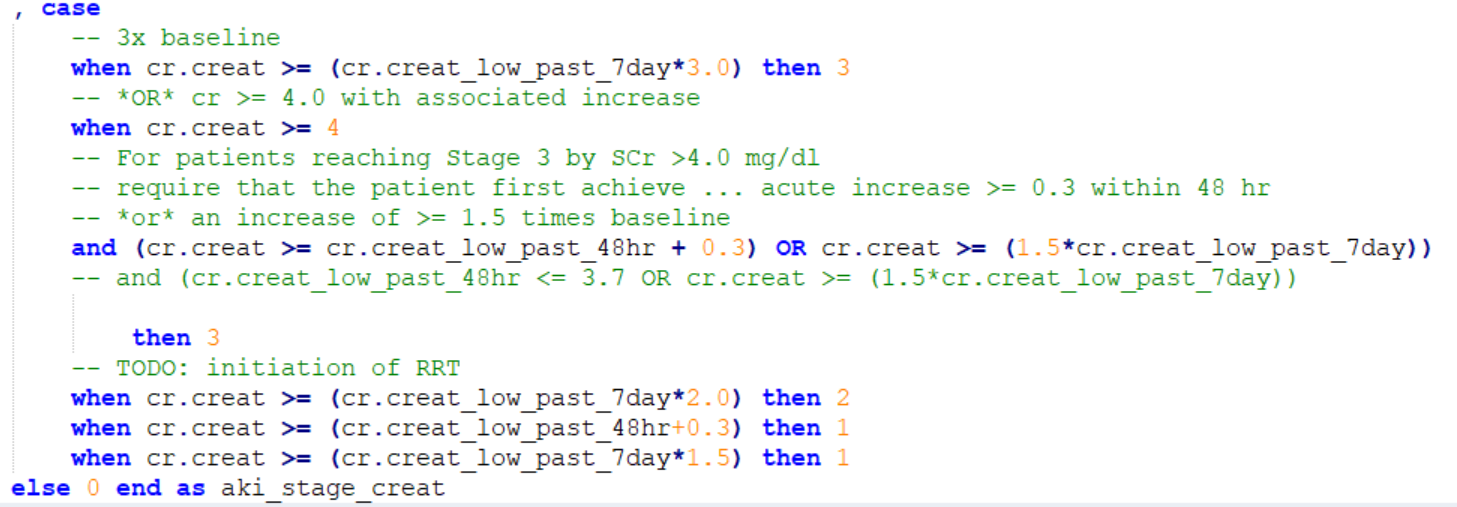

In [11]:
##读取数据##
numerics_creatinine = pd.read_csv("AKI_for_creatinine.csv")
numerics_creatinine.loc[(numerics_creatinine['value'] < 30), 'value'] = np.nan
numerics_creatinine = numerics_creatinine.sort_values(["admissionid","measuredat"])

In [12]:
# 获得基线肌酐
tmp_df = numerics_creatinine.loc[(numerics_creatinine['time'] <= 24) & (numerics_creatinine['time'] >= -365*24)]
baseline_creatinine = tmp_df.groupby(['admissionid']).agg(
        baseline_creatinine=pd.NamedAgg(column='value', aggfunc='min')
    ).reset_index()
del tmp_df
baseline_creatinine.to_csv("./baseline_creatinine.csv",index=False)

In [13]:
# 得到过去48小时内的最小值
numerics_creatinine = numerics_creatinine.loc[numerics_creatinine['time'] >= -48]
tmp_df = pd.DataFrame()
for i,j in numerics_creatinine.groupby("admissionid"):
    j["creat_low_past_48hr"] = j["value"].rolling(window=4,min_periods=1).min()
    tmp_df = pd.concat([tmp_df,j],axis=0)
numerics_creatinine = tmp_df

In [14]:
## 获取每小时的最大肌酐值##
max_creatinine = numerics_creatinine.loc[numerics_creatinine['time'] >= 0]
max_creatinine = max_creatinine.groupby(['admissionid', 'time']).agg(
        max_creatinine=pd.NamedAgg(column='value', aggfunc='max')).reset_index()


In [15]:
# Merge baseline on admissionid only and max on both admissionid and time
numerics_creatinine = numerics_creatinine[numerics_creatinine.time>=0][["admissionid","measuredat","time","creat_low_past_48hr"]]
creatinine = pd.merge(numerics_creatinine, max_creatinine, on=['admissionid', 'time'], how='right')
creatinine = pd.merge(creatinine, baseline_creatinine, on='admissionid', how='left')

creatinine = creatinine.sort_values(["admissionid","measuredat"])
creatinine.head(1)

,admissionid,measuredat,time,creat_low_past_48hr,max_creatinine,baseline_creatinine
0,0,21960000,6,86.0,86.0,86.0


In [17]:
# AKI definition
creatinine.loc[(creatinine["max_creatinine"]!=0),"aku_stage_creat"] = 0
creatinine.loc[(
        (creatinine['baseline_creatinine'] > 0) & (creatinine['max_creatinine'] / creatinine['baseline_creatinine'] >= 3)),
    'aku_stage_creat'] = 3
# AKI definition: increase to >= 354 umol/l (4mg/dl )AND at least 44 umol/l (0.5 mg/dl)increase
creatinine.loc[(
        (creatinine['max_creatinine'] >= 354) & ((creatinine['max_creatinine'] - creatinine['creat_low_past_48hr']) >= 44)),
    'aku_stage_creat'] = 3
creatinine.loc[(
        (creatinine['baseline_creatinine'] > 0) & (creatinine['max_creatinine'] / creatinine['baseline_creatinine'] >= 2)),
    'aku_stage_creat'] = 2
creatinine.loc[(
        (creatinine['baseline_creatinine'] > 0) & (creatinine['max_creatinine'] / creatinine['baseline_creatinine'] >= 1.5)),
    'aku_stage_creat'] = 1
creatinine.loc[(
        (creatinine['baseline_creatinine'] > 0) & ((creatinine['max_creatinine'] - creatinine['creat_low_past_48hr']) >= 26.5)),
    'aku_stage_creat'] = 1
creatinine.loc[creatinine["max_creatinine"].isnull(),"aku_stage_creat"] = np.nan

creatinine.drop(columns=['measuredat'],inplace=True)
creatinine= creatinine.rename(columns= {"max_creatinine":"creatinine","aku_stage_creat":"aki_stage_creat"})
creatinine.to_csv("aki_stage_creatinine.csv",index=False)

creatinine.head(1)

,admissionid,time,creat_low_past_48hr,creatinine,baseline_creatinine,aki_stage_creat
0,0,6,86.0,86.0,86.0,0.0


# 合并生成最终文件

- stay_id, time, 
- creatinine, aku_stage_creat, 
- uo_rt_6hour, uo_rt_12hour, uo_rt_24hour, aki_stage_uo, 
- aki_stage

In [26]:
import pandas as pd
creatinine = pd.read_csv("aki_stage_creatinine.csv")
uo = pd.read_csv("aki_stage_uo.csv")


In [27]:
df_aki = pd.merge(uo,creatinine,how="outer", on=["admissionid","time"])
df_aki["aki_stage"] = df_aki[["aki_stage_creat","aki_stage_uo"]].max(axis=1)


In [28]:
import math
aki_idlst = []
for i, j in df_aki.groupby("admissionid"):
    j_aki_stage = j.aki_stage.unique().tolist()
    j_aki_stage = [x for x in j_aki_stage if math.isnan(x) == False]
    if len(j_aki_stage) > 0:
        aki_idlst.append(i)

In [29]:
df_aki_ = df_aki[df_aki.admissionid.isin(aki_idlst)]
df_aki_.to_csv("kdigo_aki_stage.csv",index=False)